# Interactive, single-column RRTM for the tropical atmosphere
Adam Sokol <br>
Jan 5, 2026 <br>

This notebook uses the climlab RRTM engine to do single-column radiative transfer calculations using RRTM's reference tropical atmosphere.<br>
The user can alter the humidity profiles and add ice and liquid cloud layers with specified microphysical properties. 

In [43]:
import climlab
import copy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

# Read in reference tropical profile and build RRTM wrapper

In [44]:
ref = xr.open_dataset('tropical_profile.nc')

In [7]:
# Interpolate to a finer pressure grid for greater control of cloud top and base heights
# We will take all pressure levels > 30 hPa and bisect them and interpolate everything.
trop = ref.p.values[ref.p.values>=30]
midpts = 0.5*(trop[1:]+trop[:-1])
newp = np.sort(np.array(list(ref.p.values)+list(midpts)))

# Interpolate to new pressure grid
ref = ref.interp(p=newp)

# Fix layer thickness parameters to the new grid
plev = np.array([0.0003] + list(0.5*(newp[1:]+newp[:-1])) + [1013.0])
ref['dp'] = (('p'), plev[1:] - plev[:-1])

zlay = ref.z.values
zlev = np.array([2*zlay[0]-0.5*(zlay[0]+zlay[1])] + list((zlay[1:]+zlay[:-1])/2) + [0])
ref['dz'] = (('p'), zlev[:-1]-zlev[1:])

In [48]:
def run_rad(qv=None, co2=287, 
            icth=None, icbh=None, iwp=None, re_ice=20, 
            lcth=None, lcbh=None, lwp=None, re_liq=10, 
            saturate_cloud=True,
            S0=551.58, zenith_angle=42.05):
    """
    Main engine for the single-column RRTM model.
        1. Builds single-column profile with specified cloud & moisture properties
        2. Runs profile through RRTM using climlab
        3. Puts all input and output into a single xarray Dataset to return
    
    For cloud layers, we assume that the ice/liquid mixing ratio and effective radius
    are vertically uniform. The user specifies the cloud top height, base height, and
    total liquid/ice water path. The vertically uniform ice/liquid mixing ratio is then 
    found by iterating until the total layer ice/liquid water path matches the 
    user-specified input. The condensate mixing ratios are not actually used by RRTM but 
    are used to find the total condensate path of each vertical level.

    For now, only one ice cloud layer and/or one liquid cloud layer can be inserted.
        
    Args:
        %%%%%%% Moisture fields %%%%%%%
        - qv: specific humidity profile (kg/kg) (default=None uses the reference profile)
        - saturate_cloud: if True, automatically sets q=qsat for all cloudy levels

        %%%%%%% CO2 %%%%%%%
        - co2: CO2 concentration in ppmv
        
        %%%%%%% Ice cloud properties %%%%%%%
        - icth: ice cloud top height (KM)
        - icbh: ice cloud base height (KM)
        - iwp: ice cloud ice water path (G/M2)
        - re_ice: ice effective radius (MICROMETERES)

        %%%%%%% Liquid cloud properties %%%%%%%
        - lcth: liquid cloud top height (KM)
        - lcbh: liquid cloud base height (KM)
        - lwp: liquid cloud liquid water path (G/M2)
        - re_liq: liquid droplet effective radius (MICROMETERS)

        %%%%%%% SOLAR PARAMETERS %%%%%%%
        - S0: solar constant (W/m2)
        - zenith_angle: solar zenith angle (degrees)
        
    Returns:
        xr.Dataset() containing all input and output fields.
    """

    # Combine trace gas concentrations 
    co2 = co2*1e-6 if co2>1 else co2 # ensure CO2 is a volume mixing ratio rather than ppmv
    gas_vmr = {'CO2':np.array([co2]),    'CH4':ref.CH4vmr.values,
               'N2O':ref.N2Ovmr.values,  'O2':ref.O2vmr.values,
               'O3':ref.O3vmr.values,    'CFC11':0.,  
               'CFC12':0.,  'CFC22':0.,
               'CCL4':0.,   'CO':0.,}
    
    ###############################
    ########## Ice Cloud ##########
    # create ice cloud fraction profile
    icldfrac = np.zeros(ref.z.values.shape) 
    if icth:
        iicth = abs(ref.z-icth).argmin('p').values
        iicbh = abs(ref.z-icbh).argmin('p').values
        icldfrac[iicth:iicbh+1] = 1
    
    # ice effective radius
    re_ice_prof = icldfrac * re_ice

    # Get layer-wise IWP from specified total IWP assuming vertically
    # uniform ice mixing ratio and vertically varying air density
    ciwp, qi_prof = np.zeros(ref.p.shape), np.zeros(ref.p.shape)
    if iwp:
        # given qi (g/kg), this function gets the IWP (g/m2) of the cloud layer
        get_iwp = lambda qi: (qi * ref.rho * (ref.dz*1000) * icldfrac).sum('p')
        qi = fsolve(lambda qi: get_iwp(qi)-iwp, x0=1e-1) # gets qi (g/kg) that produces the desired IWP (g/m2)
        qi_prof = qi * icldfrac
        ciwp = (icldfrac * qi_prof * ref.rho * (ref.dz*1000)).values # IWP (g/m2) of each vertical layer
    else:
        iwp = 0

    ##################################
    ########## Liquid Cloud ##########
    # liquid cloud fraction profile
    lcldfrac = np.zeros(ref.z.values.shape)
    if lcth:
        ilcth = abs(ref.z-lcth).argmin('p').values
        ilcbh = abs(ref.z-lcbh).argmin('p').values
        lcldfrac[ilcth:ilcbh+1] = 1
    
    # total (ice+liq) cloud fraction profile
    cldfrac = np.maximum(icldfrac, lcldfrac)
    
    # liq effective radius
    re_liq_prof = lcldfrac * re_liq

    # Get layer-wise LWP from specified total LWP assuming vertically
    # uniform liq mixing ratio and vertically varying air density
    clwp, qc_prof = np.zeros(ref.p.shape), np.zeros(ref.p.shape)
    if lwp:
        # given qc (g/kg), this function gets the LWP (g/m2) of cloud layer
        get_lwp = lambda qc: (qc * ref.rho * (ref.dz*1000) * lcldfrac).sum('p')
        # get qc (g/kg) that produces the desired column LWP (g/m2)
        qc = fsolve(lambda qc: get_lwp(qc)-lwp, x0=1e-1)
        qc_prof = qc * cldfrac
        clwp = (lcldfrac * qc_prof * ref.rho * (ref.dz*1000)).values # LWP (g/m2) of each vertical layer
    else:
        lwp = 0

    ##################################
    ########## Water Vapor ##########
    
    if qv is None: # default to reference profile if no qv provided
        qv = ref.q.values
        
    if saturate_cloud: # enforce q=qsat within cloudy levels
        qv = xr.where(cldfrac, ref.qsat.values, qv)

    #############################################
    ########## Run RRTM using Climlab ##########
    
    # Create a single-column atmosphere model
    state = climlab.column_state(lev=ref.p)
    state['Ts'][:] = ref.SST
    state['Tatm'][:] = ref.T

    cos_sza = np.cos(np.deg2rad(zenith_angle)) # cosine of solar zenith angle

    rad = climlab.radiation.RRTMG(
                              state=state, 
                              specific_humidity=qv,   # specific humidity (kg/kg)
                              icld=1,                 # cloud overlap (0=clr, 1=random, 2=max/random, 3=random
                              inflgsw  = 2,           # 2: SW optical depth of each layer computed rather than specified
                              inflglw  = 2,           # 2: LW optical depth of each layer computed rather than specified
                              iceflgsw = 3,           # uses Fu 1998 parameterization
                              iceflglw = 3,           # uses Fu 1998 parameterization
                              liqflgsw = 1,           # 1=nongrey
                              liqflglw = 1,           # 1=nongrey
                              cldfrac = cldfrac,      # cloud fraction (ice + liq combined)
                              clwp = clwp,            # g/m2
                              ciwp = ciwp,            # g/m2
                              r_liq = re_liq,         # microns
                              r_ice = re_ice_prof,    # microns
                              tauc_sw = 0.,           # In-cloud optical depth (not used)
                              tauc_lw = 0.,           # in-cloud optical depth (not used)
                              ssac_sw = 0.,           # In-cloud single scattering albedo (not used)
                              asmc_sw = 0.,           # In-cloud asymmetry parameter (not used)
                              fsfc_sw = 0.,           # In-cloud forward scattering fraction (not used)
                              albedo = 0.07,          # SW surface albedo
                              absorber_vmr = gas_vmr, # trace gas concentrations
                              S0 = S0,                # solar constant W/m2
                              coszen = cos_sza        # cosine of solar zenith angle
                              )  
    
    #####################################################
    ########## Package everything into Dataset ##########
    
    rad.compute_diagnostics()
    diag = rad.diagnostics
    out = ref.copy()
    out['q'] = (('p'), qv)                   # specific humidity
    out['rh'] = out.q / ref.qsat             # relative humidity
    out['iwp'] = ((), iwp)                   # total column ice water path (g/m2)
    out['ciwp'] = (('p'), ciwp)              # layer cloud ice water path (g/m2)
    out['qi'] = (('p'), qi_prof)             # cloud ice mixing ratio (kg/kg)
    out['lwp'] = ((), lwp)                   # total column liquid water path (g/m2)
    out['clwp'] = (('p'), clwp)              # layer cloud liquid water path (g/m2)
    out['qc'] = (('p'), qc_prof)             # cloud liquid mixing ratio (kg/kg)
    out['cldfrac'] = (('p'), cldfrac)        # cloud fraction profile
    
    out['Q'] = (('p'), diag['TdotSW'] + diag['TdotLW'])            # total radiative heating rate
    out['Qsw'] = (('p'), diag['TdotSW'])                           # SW radiative heating rate
    out['Qlw'] = (('p'), diag['TdotLW'])                           # LW radiative heating rate
    out['Qclr'] = (('p'), diag['TdotSW_clr'] + diag['TdotLW_clr']) # total clear-sky radiative heating rate
    out['Qclrsw'] = (('p'), diag['TdotSW_clr'])                    # SW clear-sky radiative heating rate
    out['Qclrlw'] = (('p'), diag['TdotLW_clr'])                    # LW clear-sky radiative heating rate
    out['Qcld'] = out.Q - out.Qclr                                 # cloud radiative effect
    out['Qcldsw'] = out.Qsw - out.Qclrsw                           # SW cloud radiative effect
    out['Qcldlw'] = out.Qlw - out.Qclrlw                           # LW cloud radiative effect

    out['OLR'] = diag['OLR'][0]                    # outgoing LW (W/m2)
    out['OLRclr'] = diag['OLRclr'][0]              # clear-sky outgoing LW (W/m2)
    out['ASR'] = diag['ASR'][0]                    # absorbed SW (W/m2)
    out['ASRclr'] = diag['ASRclr'][0]              # clear-sky absorbed SW (W/m2)

    out['lwcre'] = out['OLRclr'] - out['OLR']      # TOA LW cloud radiative effect (W/m2)
    out['swcre'] = out['ASR'] - out['ASRclr']      # TOA SW cloud radiative effect (W/m2)
    out['ncre'] =  out['lwcre'] + out['swcre']     # TOA net cloud radiative effect (W/m2)

    # Estimate SW optical depth using tau=(3/2) * IWP / (re_ice * rho_ice) (Hartmann GPC Textbook)
    rhoi = 917  # ice density, kg/m3
    out['tau_sw'] = 1.5 * (out.iwp/1000) / (re_ice*1e-6 * rhoi)

    # Estimate 11-micron brightness temp following Ohring et al (1984)
    sigma = 5.67037e-8 # stefan-boltzmann constant W/m2/K
    out['BT_OLR'] = (out.OLR/sigma)**0.25
    out['BT_OLRclr'] = (out.OLRclr/sigma)**0.25
    a = 1.228
    b = -1.106e-3
    get_t_olr = lambda bt11: bt11 * (a + b * bt11)
    bt11 = fsolve(lambda bt11: get_t_olr(bt11)-out.BT_OLR.values, x0=out.BT_OLR+15)[0]
    out['BT11'] = ((), bt11) # Kelvin

    return out

# Cloud-free radiative heating profiles and CO$_2$

In [49]:
ds = run_rad(co2=287)
ds4x = run_rad(co2=4*287)

Text(0.5, 0, 'K/day')

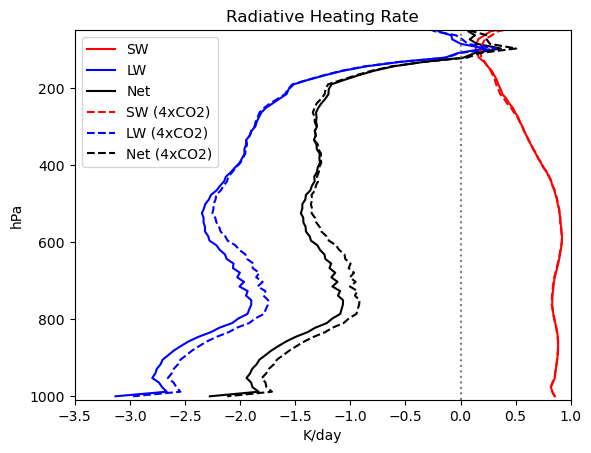

In [65]:
fig, ax = plt.subplots()
ds.Qsw.plot(color='r', label='SW', y='p',)
ds.Qlw.plot(color='b', label='LW', y='p',)
ds.Q.plot(color='k', label='Net', y='p',)
ds4x.Qsw.plot(color='r', ls='--', label='SW (4xCO2)', y='p',)
ds4x.Qlw.plot(color='b', ls='--', label='LW (4xCO2)', y='p',)
ds4x.Q.plot(color='k', ls='--', label='Net (4xCO2)', y='p',)
plt.ylim(1010,50)
plt.xlim(-3.5, 1)
plt.axvline(color='tab:grey', ls=':')
plt.legend(loc='upper left')
plt.title('Radiative Heating Rate')
plt.ylabel('hPa')
plt.xlabel('K/day')

# Cirrus cloud radiative effect as a function of IWP

In [72]:
cth = 14                              # cloud top height (km)
cbh = 10                              # cloud base height (km)
iiwps = 10**np.arange(-1, 3.1, 0.1)   # IWPs to test

ds = xr.concat([run_rad(icth=cth, icbh=cbh, iwp=iiwp) for iiwp in iiwps], dim='iwp')

Text(0.5, 1.0, 'Cirrus cloud radiative effect as a function of IWP')

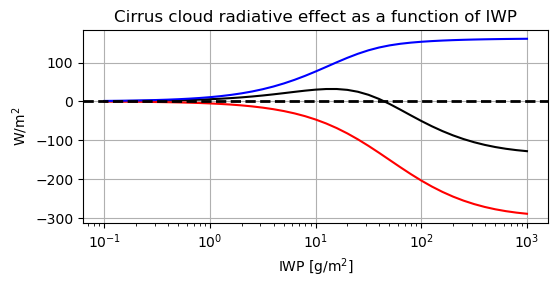

In [73]:
plt.figure(figsize=(6,2.5))
ds.ncre.plot(xscale='log', color='k', label='Net CRE')
ds.swcre.plot(xscale='log', color='r', label='SW CRE')
ds.lwcre.plot(xscale='log', color='b', label='LW CRE')
plt.grid(), plt.axhline(color='k', lw=2, ls='--')
plt.ylabel('W/m$^2$'), plt.xlabel('IWP [g/m$^2$]')
plt.title('Cirrus cloud radiative effect as a function of IWP')


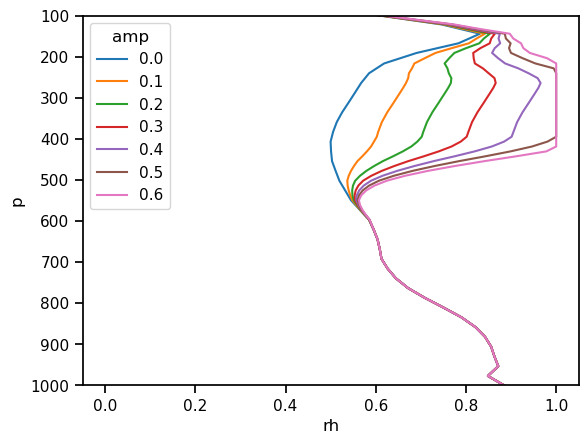

In [127]:
ds.rh.plot.line(y='p', ylim=(1000,100))

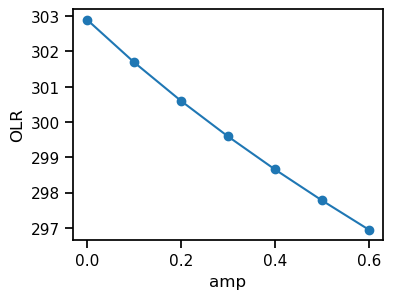

In [107]:
ds.OLR.plot(marker='o', figsize=(4,3))